In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm

sns.set_style("white")

# Clustering users w GMM

In [2]:
ratings = pd.read_csv("ratings.csv")
tags = pd.read_csv("tags.csv")

In [3]:
user_df = pd.DataFrame({"userId" : [x for x in range(1, 283229)],
                        "Num Ratings": list(ratings.groupby("userId")["movieId"].count())})

In [4]:
user_df["Num Tags"] = tags.groupby("userId")["tag"].count()
user_df["Tagger"] = ~user_df["Num Tags"].isnull()
user_df["Tagger"] = ~user_df["Num Tags"].isnull()
user_df["Avg Rating"] = ratings.groupby("userId")["rating"].mean()

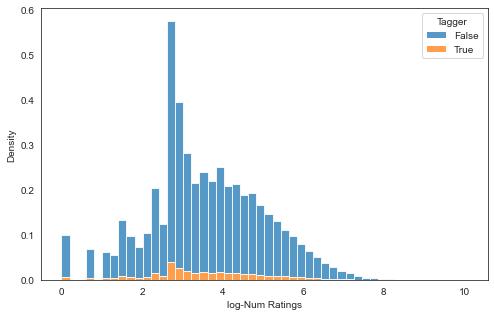

In [5]:
plt.figure(figsize = (8, 5))
g = sns.histplot(data = user_df, x = np.log(user_df["Num Ratings"]), bins = 50, 
                hue = "Tagger", log_scale = False, multiple = "stack", stat = "density")
g.set(xlabel = "log-Num Ratings")
plt.savefig("rating+tagging_hist.png", dpi = 300)
plt.show()

In [80]:
#test if taggers and non-taggers have same distribution
#fit mixture of two gaussians to #ratings
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=2)
log_ratings = np.log(np.array(user_df["Num Ratings"]).reshape(-1,1))
labels = model.fit_predict(log_ratings)
user_df["Type"] = labels

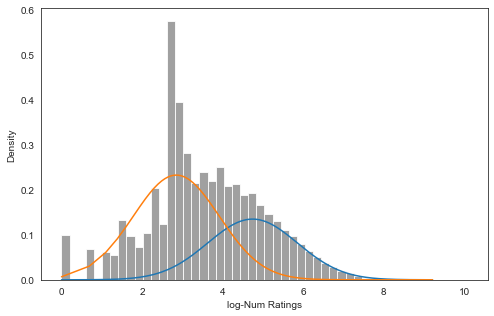

In [93]:
from scipy import stats

plt.figure(figsize = (8, 5))

weights = model.weights_
means = model.means_
covars = model.covariances_

grid = np.log(np.arange(1, 1e4, 1))

g = sns.histplot(data = user_df, x = np.log(user_df["Num Ratings"]), bins = 50, log_scale = False, stat = "density",
                color= "grey")


plt.plot(grid, weights[1]*stats.norm.pdf(grid, means[1], np.sqrt(covars[1])).ravel())
plt.plot(grid, weights[0]*stats.norm.pdf(grid, means[0], np.sqrt(covars[0])).ravel())

g.set(xlabel = "log-Num Ratings")
plt.savefig("ratings_hist_fitted.png", dpi = 300)


In [8]:
from scipy.stats import mannwhitneyu
mannwhitneyu(user_df[user_df["Tagger"]]["Num Ratings"], user_df[~user_df["Tagger"]]["Num Ratings"])

MannwhitneyuResult(statistic=2546992796.5, pvalue=0.3932850836890581)

# Focus group design

In [47]:
movies_df = pd.read_csv("movies.csv")
#movies_df["Num Ratings"] = 
movies_df = pd.merge(movies_df, np.log(ratings.groupby("movieId")["rating"].count()), on = "movieId")
movies_df

,movieId,title,genres,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.134136
1,2,Jumanji (1995),Adventure|Children|Fantasy,10.208874
2,3,Grumpier Old Men (1995),Comedy|Romance,9.654064
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,8.002694
4,5,Father of the Bride Part II (1995),Comedy,9.646916
...,...,...,...,...
53884,193876,The Great Glinka (1946),(no genres listed),0.000000
53885,193878,Les tribulations d'une caissière (2011),Comedy,0.000000
53886,193880,Her Name Was Mumu (2016),Drama,0.000000
53887,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi,0.000000


In [48]:
ratings

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


In [49]:
merged_df = pd.merge(ratings, user_df, on = "userId")

In [50]:
movies_df

,movieId,title,genres,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.134136
1,2,Jumanji (1995),Adventure|Children|Fantasy,10.208874
2,3,Grumpier Old Men (1995),Comedy|Romance,9.654064
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,8.002694
4,5,Father of the Bride Part II (1995),Comedy,9.646916
...,...,...,...,...
53884,193876,The Great Glinka (1946),(no genres listed),0.000000
53885,193878,Les tribulations d'une caissière (2011),Comedy,0.000000
53886,193880,Her Name Was Mumu (2016),Drama,0.000000
53887,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi,0.000000


In [51]:
movies_df = pd.merge(movies_df, merged_df[merged_df["Type"] == 1].groupby("movieId")["rating"].median(), on = "movieId")
movies_df = pd.merge(movies_df, merged_df[merged_df["Type"] == 0].groupby("movieId")["rating"].median(), on = "movieId")

In [52]:
movies_df

,movieId,title,genres,rating_x,rating_y,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.134136,4.00,4.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,10.208874,3.00,4.0
2,3,Grumpier Old Men (1995),Comedy|Romance,9.654064,3.00,3.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,8.002694,3.00,3.0
4,5,Father of the Bride Part II (1995),Comedy,9.646916,3.00,3.0
...,...,...,...,...,...,...
19818,193801,Lupin the Third: The Blood Spray of Goemon Ish...,Action|Animation|Crime,0.693147,4.00,5.0
19819,193803,Bleach: Memories of Nobody (2006),Animation|Fantasy|Sci-Fi,1.098612,2.75,5.0
19820,193821,Nappily Ever After (2018),Comedy|Romance,1.098612,2.50,0.5
19821,193849,Rafinha Bastos: Ultimatum (2018),(no genres listed),0.693147,3.00,0.5


In [53]:
movies_df.columns = ["movieId", "title", "genres", "Num Ratings", "Mean-1", "Mean-0"]
movies_df

,movieId,title,genres,Num Ratings,Mean-1,Mean-0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.134136,4.00,4.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,10.208874,3.00,4.0
2,3,Grumpier Old Men (1995),Comedy|Romance,9.654064,3.00,3.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,8.002694,3.00,3.0
4,5,Father of the Bride Part II (1995),Comedy,9.646916,3.00,3.0
...,...,...,...,...,...,...
19818,193801,Lupin the Third: The Blood Spray of Goemon Ish...,Action|Animation|Crime,0.693147,4.00,5.0
19819,193803,Bleach: Memories of Nobody (2006),Animation|Fantasy|Sci-Fi,1.098612,2.75,5.0
19820,193821,Nappily Ever After (2018),Comedy|Romance,1.098612,2.50,0.5
19821,193849,Rafinha Bastos: Ultimatum (2018),(no genres listed),0.693147,3.00,0.5


In [54]:
M = movies_df[["Num Ratings", "Mean-1", "Mean-0"]].to_numpy()

In [55]:
y = M[:,0]
X = M[:,1:]


In [56]:
import statsmodels.api as sm

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     623.6
Date:                Sat, 03 Oct 2020   Prob (F-statistic):          2.36e-263
Time:                        20:43:37   Log-Likelihood:                -43459.
No. Observations:               19823   AIC:                         8.692e+04
Df Residuals:                   19820   BIC:                         8.695e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0614      0.083     24.773      0.000       1.898       2.225
x1             0.7696      0.025     30.480      0.000       0.720       0.819
x2             0.0897      0.016      5.501      0.000       0.058       0.122
==============================================================================
Omnibus:                      524.258   Durbin-Watson:                   0.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              352.363
Skew:                           0.209   Prob(JB):                     3.06e-77
Kurtosis:                       2.498   Cond. No.                         28.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
np.corrcoef(y, X[:,2])

array([[1.        , 0.12287303],
       [0.12287303, 1.        ]])

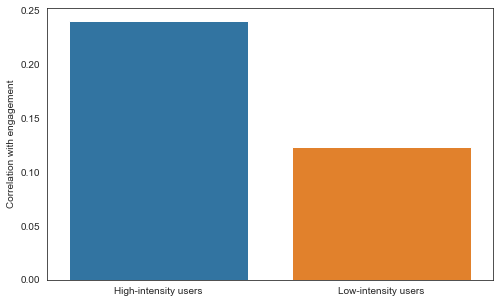

In [87]:
plt.figure(figsize = (8,5))
ax = sns.barplot(x = ["High-intensity users", "Low-intensity users"], y= [0.24033365, 0.12287303])
ax.set(ylabel = "Correlation with engagement")
plt.savefig("cor.png")
